# Individual Experimentation

Name: Dennis Ocaka <br>
Username: do00204  <br>
URN: 6494685

In [86]:
# Import Modules

!pip install pickle5
import pickle5 as pickle
import pandas as pd
import numpy as np
import utils
import keras
import h5py
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, SpatialDropout1D
import matplotlib.pyplot as plt
%matplotlib inline



     |████████████████████████████████| 132 kB 3.7 MB/s eta 0:00:01
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=243479 sha256=a909a87983357cfce1aaa486b82b67dafb93a3621acbec41cf11f21602d7a91a
  Stored in directory: /home/dennis/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [83]:
# Define Constants

TRAIN_DATASET = "train.csv"
TEST_DATA = "test.csv"
TEST_LABELS = "test_labels.csv"
REDUNDANT_FIELDS = ["id"]
DATA_FIELD = ["comment_text"]
LABEL_FIELDS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]


# Datasets
BALANCED_TRAIN_DATASET = "balanced_dataset.pickle"
BALANCED_TEST_DATASET = "balanced_test_dataset.pickle"

# Read in data

In [98]:
def load_pickle(file_path):
    return pickle.load(open(file_path, "rb"))


# Function to pickle final pre-processed data
# Params: 
    # List - tokens that have been fully pre-processed
    # Str - file name
# Output: Pickle file in directory/repo 
def save_pickle(preprocessed, file_name):
    pickle.dump(preprocessed, open("{0}.pickle".format(file_name), "wb"))

In [102]:
# Balanced, unprocessed datasets
bal_train_df = load_pickle(BALANCED_TRAIN_DATASET)
bal_test_df = load_pickle(BALANCED_TEST_DATASET)

In [103]:
# Read in training dataset
train = pd.read_csv(TRAIN_DATASET)

# Read in test data and labels
test_data = pd.read_csv(TEST_DATA)
test_labels = pd.read_csv(TEST_LABELS)

# Combine test data and labels into one data frame
test = pd.concat([test_data, test_labels], axis=1)

# Remove redundant id field from both datasets
train = train.drop(columns=REDUNDANT_FIELDS)
test = test.drop(columns=REDUNDANT_FIELDS)

# Remove samples with labels containing -1 in test dataset, this 
# is a place holder for samples that were not assigned labels.
test = test.drop(test[(test.toxic == -1) |
                      (test.severe_toxic == -1) |
                      (test.obscene == -1) |
                      (test.threat == -1) |
                      (test.insult == -1) |
                      (test.identity_hate == -1)].index)

# Visualise Data

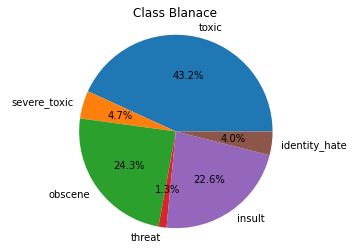

True

In [104]:
def visualise_data(data):

    classes = {}

    for index in range(1,7):
        classes.update({data.iloc[:,index].name : np.histogram(data.iloc[:,index], bins=2)[0]})

    labels = list(classes2.keys())
    values = list(classes2.values())
    data = [values[x][1] for x in range(0,len(values))]

    plt.pie(data,labels=labels,autopct='%1.1f%%')
    plt.title('Class Blanace')
    plt.axis('equal')
    plt.show()
    
    return True
    
    
# Balanced Dataset
visualise_data(train)

# Normalise and Clean Data

In [6]:
# Remove punctuation
regex_str = "[^a-zA-Z\s]"
train['comment_text'] = train['comment_text'].replace(regex=regex_str, value="")

# Remove extra whitespaces
regex_space = "\s+"
train['comment_text'] = train['comment_text'].replace(regex=regex_space, value=" ")

# Strip whitespaces
train['comment_text'] = train['comment_text'].str.strip()

# Lowercase
train['comment_text'] = train['comment_text'].str.lower()

# Convert comment_text column into a list
comment_list = train['comment_text'].tolist()

# Experiment 1

Text Enrichment:

Involves augmenting your original text data with information that you did not previously have. Text enrichment provides more semantics to your original text, therby improving its predictive power and the depth of analysis you can perform on your data.


References:https://medium.com/opla/text-augmentation-for-machine-learning-tasks-how-to-grow-your-text-dataset-for-classification-38a9a207f88d


# Technique 1: Synonym replacement

This technique aims at replacing some words by their synonyms and expressions by their paraphrases.

In [7]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from utils import read_datasets

stoplist = stopwords.words('english')



def get_synonyms_lexicon(path):
    
    "Fetch set of synonyms from specified path directory "
    
    synonyms_lexicon = {}
    text_entries = [l.strip() for l in open(path).readlines()]
    
    for e in text_entries:
        e = e.split(' ')
        k = e[0]
        v = e[1:len(e)]
        synonyms_lexicon[k] = v
        
    return synonyms_lexicon


def synonym_replacement(sentence, synonyms_lexicon):
    
    keys = synonyms_lexicon.keys()
    words = word_tokenize(sentence)
    n_sentence = sentence
    for w in words:
        if w not in stoplist:
            if w in keys:
                n_sentence = n_sentence.replace(w, synonyms_lexicon[w][0])  # we replace with the first synonym
    return n_sentence




We can now apply the synonym replacement to each comment, as the dataset does not contain a replacement for each comment not all comments will have variations.

In [10]:
synonyms_lexicon = get_synonyms_lexicon('./ppdb-xl.txt')

new_train = list()


# read in normalized train data
for index, row in train.iterrows():

    new_train.append(row)
    text = row['comment_text']
    augmented_row = row


    augmented_row['comment_text'] = synonym_replacement(text, synonyms_lexicon)


    if augmented_row['comment_text'] != text:
        new_train.append(augmented_row)


Number of samples in original:  159571
Number of samples in augmented:  286027


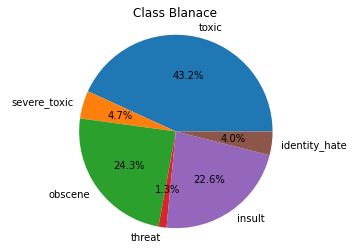

True

In [17]:
print("Number of samples in original: ", len(train))
print("Number of samples in augmented: ", len(new_train))

augmented_train = pd.DataFrame(new_train)

visualise_data(augmented_train)

# Technique 2: Word/sentence shuffling

In [ ]:
from nltk import word_tokenize
import random


def shuffle(sen, n):
    
    # stores newly augmented sentences
    new_sentences = []
    # returns a list of tokenized words
    words = word_tokenize(sen)
    
    for i in range(n):
        random.shuffle(words)
        new_sentences.append(' '.join(words))
    # remove duplicates    
    new_sentences = list(set(new_sentences))
    
    return new_sentences

In [ ]:
shuffle_sen = shuffle(comment_list[1], 5)
    
new_train = list()
inter = 5

# read in normalized train data
for index, row in train.iterrows():

    new_train.append(row)
    text = row['comment_text']
    augmented_row = row

    for i in range(inter):
    augmented_row['comment_text'] = shuffle(text, 5)
    
    new_train.append(augmented_row)


# Experiment 2 

- Regularisation
- l2 (wegiht decay, or ridge regression) adds a penalty for the complexity of a model
- l1 makes the less important features to zero

# Base model

In [ ]:
# Train Base model

model.fit(x_train, y_train, epochs=15, batch_size=60,  validation_data=(x_val, y_val))

In [77]:
# Load in model
import utils

num_words = 20000
max_len = 80

model = utils.build_model(num_words)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              